In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from PIL import Image
import PIL

from pathlib import Path
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
"""
Загрузка датасета Caltech 101
http://www.vision.caltech.edu/Image_Datasets/Caltech101/
"""

!gdown --id 137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
!tar -xvzf ./101_ObjectCategories.tar.gz
!rm -rf /content/101_ObjectCategories/BACKGROUND_Google

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

def image_converter(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        # LabelEncoding
        self.labels = [path.parent.name for path in self.files]
        self.label_encoder.fit(self.labels)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # загружаем изображение, ресайз до нужного размера длинной стороны,
        # к короткой стороне изображения добавляем паддинг
        image = Image.open(file).convert('RGB')
        image.load()
        image = PIL.ImageOps.pad(image, (RESCALE_SIZE, RESCALE_SIZE))
        return image
  
    def __getitem__(self, index):
        # Преобразование изображений в тензоры PyTorch, нормализации входа
        # и 3 аугментации для train данных
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.RandomRotation(degrees=5),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = self.load_sample(self.files[index])
        x = transform(x)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()

        return x, y

In [ ]:
MAIN_DIR = Path('/content/101_ObjectCategories')
RESCALE_SIZE = 224

all_files = list(MAIN_DIR.rglob('*.jpg'))
all_labels = [path.parent.name for path in all_files]

train_files, val_files = train_test_split(all_files, test_size=0.2, \
                                          stratify=all_labels)

train_dataset = ImageDataset(train_files, mode='train')
val_dataset = ImageDataset(val_files, mode='val')

# Количество классов в данных
n_classes = len(np.unique(all_labels))
print(n_classes)

print(f"{len(all_files)} => {len(train_files)} & {len(val_files)}")

101
8677 => 6941 & 1736


In [ ]:
"""
Балансировка данных
"""
def create_dct(files, labels):
    # Формируем словарь с количеством картинок для каждого класса
    dct_images = {}
    for label in np.unique(all_labels).tolist():
        dct_images[label] = []

    for path, label in zip(files, labels):
        dct_images[label].append(path)

    return dct_images

dct_label_paths = create_dct(train_dataset.files, train_dataset.labels)

# Если картинок меньше 100, то размножаем пути для класса
min_number = 100
for label in dct_label_paths:
    if len(dct_label_paths[label]) < min_number:
        dct_label_paths[label] = dct_label_paths[label] * (min_number // len(dct_label_paths[label]))
        dct_label_paths[label].extend(dct_label_paths[label][:min_number - len(dct_label_paths[label])])
    
new_train_files = []

for label in dct_label_paths:
    new_train_files.extend(dct_label_paths[label])

train_dataset = ImageDataset(new_train_files, mode='train')
print(f"{len(train_files)} => {len(new_train_files)}")

6941 => 11827


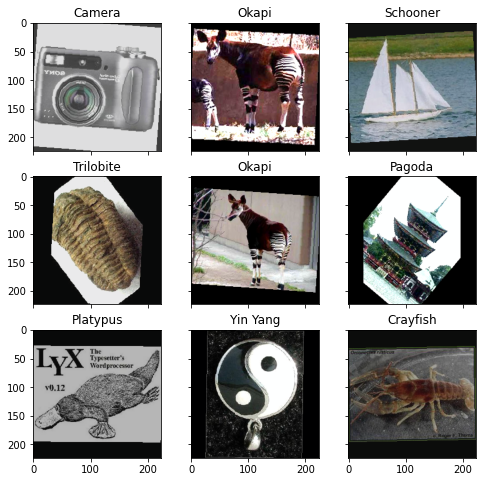

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, len(train_dataset)))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), img_label, plt_ax=fig_x)

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_dataset, val_dataset, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
        
        val_loss, val_acc = eval_epoch(model, val_loader, criterion)

        history.append((train_loss, train_acc, val_loss, val_acc))
        
        print(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(pretrained=True)

model.classifier[6] = nn.Linear(4096, n_classes)
model = model.to(DEVICE)

In [ ]:
history = train(train_dataset, val_dataset, model, epochs=10, batch_size=128)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)




Epoch 001 train_loss: 1.3356     val_loss 0.2895 train_acc 0.6845 val_acc 0.9136




Epoch 002 train_loss: 0.2139     val_loss 0.2493 train_acc 0.9363 val_acc 0.9280




Epoch 003 train_loss: 0.1065     val_loss 0.2861 train_acc 0.9697 val_acc 0.9309




Epoch 004 train_loss: 0.0658     val_loss 0.3440 train_acc 0.9813 val_acc 0.9268




Epoch 005 train_loss: 0.0582     val_loss 0.2512 train_acc 0.9821 val_acc 0.9412




Epoch 006 train_loss: 0.0452     val_loss 0.3328 train_acc 0.9873 val_acc 0.9297




Epoch 007 train_loss: 0.0499     val_loss 0.2472 train_acc 0.9858 val_acc 0.9338




Epoch 008 train_loss: 0.0408     val_loss 0.2576 train_acc 0.9875 val_acc 0.9435




Epoch 009 train_loss: 0.0418     val_loss 0.2623 train_acc 0.9889 val_acc 0.9349




Epoch 010 train_loss: 0.0360     val_loss 0.3067 train_acc 0.9910 val_acc 0.9291


In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

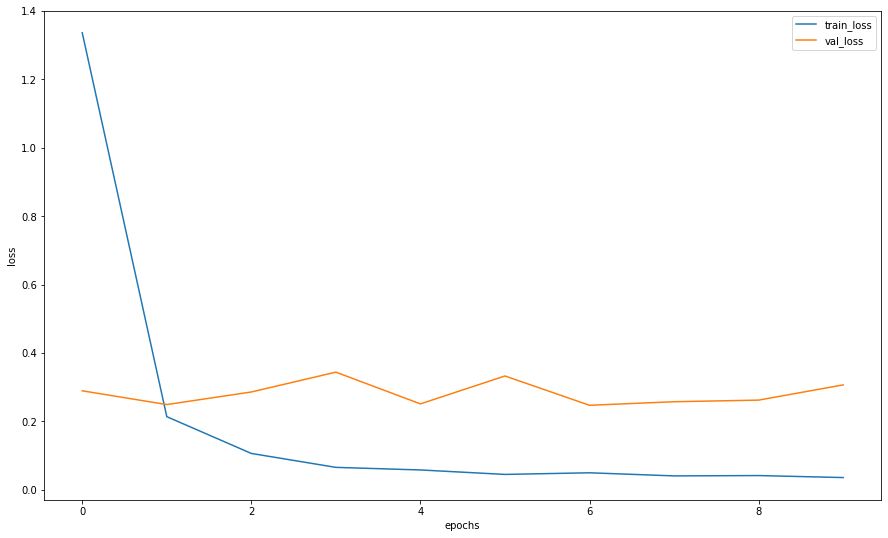

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

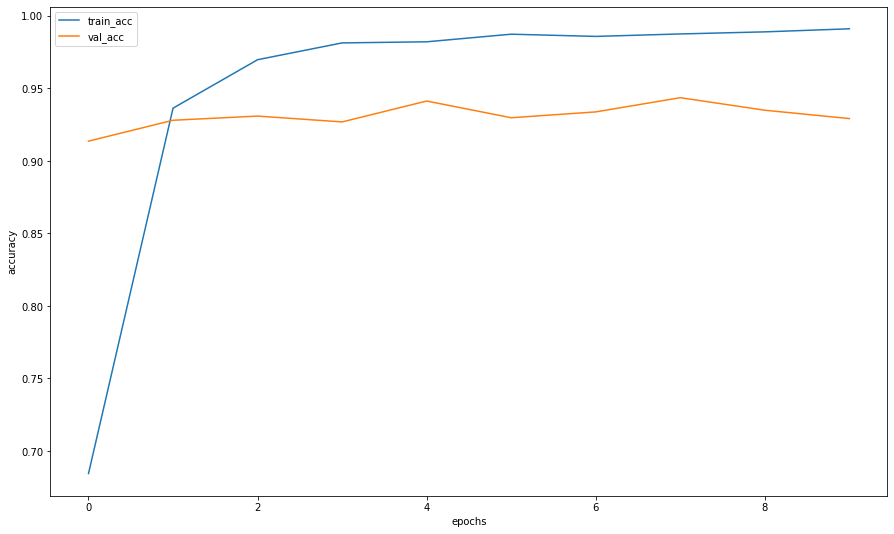

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
model_features = model.features[:11].to('cpu')
model_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
wts_path = "/content/gdrive/MyDrive/Colab_Notebooks/DL_1_semester_advanced/23_project/style_transfer/models_wts/nst_features.pth"
torch.save(model_features.state_dict(), wts_path)